# **Google Drive Mount**

Run this cell if yourdataset is inn your google drive or you want to save the trained models to drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Imports and Installs**

In [4]:

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset, Subset, random_split, Dataset
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import time
import zipfile
from PIL import Image
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import cv2
import torch.nn.functional as F
!pip install kornia
import kornia.augmentation as K
from kornia.augmentation import AugmentationSequential
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

# **Globals**

Detailed dataset Information and  download can be found [here](https://www.kaggle.com/datasets/aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented)

In [5]:
# Set the dataset root directory
dataset_root = "/content/drive/MyDrive/DL_course/Project/dataset/combined_images"
# Set the saved_models directory
saved_models_path = "/content/drive/MyDrive/DL_course/Project/saved_models"

# **Data Preproccess**

Dataset Class

In [6]:
class AlzheimerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(idx)

        data = list(zip(self.image_paths, self.labels))
        random.shuffle(data)
        subset_size = int(len(data) * 1)
        data = data[:subset_size]

        self.image_paths, self.labels = zip(*data)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:

IMAGE_SIZE = 64
batch_size = 128

Transformations, Train-Validation-Test Split, Device

In [9]:

transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor()
    ])


# Create the dataset
dataset = AlzheimerDataset(root_dir=dataset_root, transform=transform)

# Calculate split sizes
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Print the number of samples
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# Check device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device = {device}")

Number of training samples: 30841
Number of validation samples: 6609
Number of test samples: 6610
device = cuda:0


# **Data Visualization**

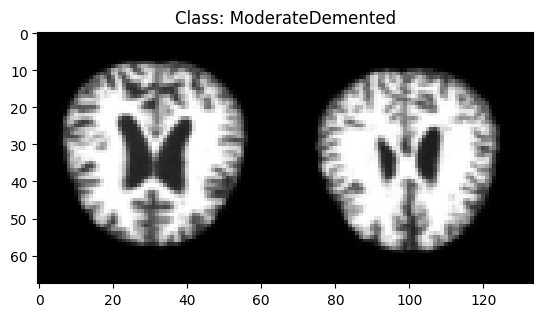

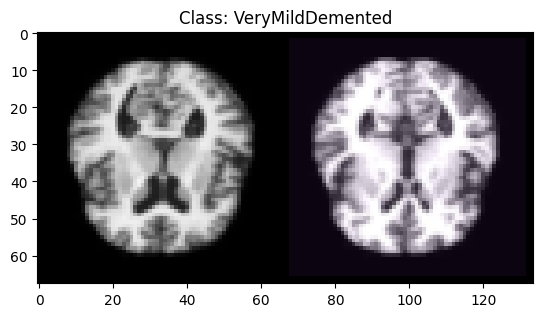

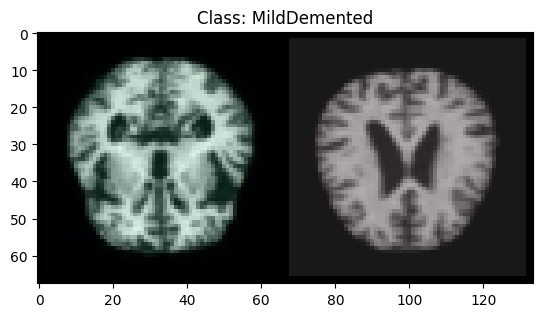

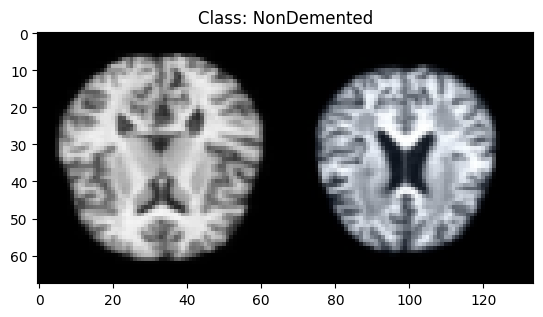

In [ ]:
# 2 samples of each class
def imshow(img, title):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

class_names = dataset.classes
samples_per_class = 2
samples = {class_name: [] for class_name in class_names}

for img, label in train_dataset:
    class_name = class_names[label]
    if len(samples[class_name]) < samples_per_class:
        samples[class_name].append(img)
    if all(len(samples[class_name]) == samples_per_class for class_name in class_names):
        break

for class_name, imgs in samples.items():
    imshow(make_grid(imgs, nrow=samples_per_class), title=f"Class: {class_name}")

# **General functions and utils**

In [10]:
def calculate_accuracy(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_images = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
    model_accuracy = total_correct / total_images * 100
    return model_accuracy

In [11]:
def plot_normalized_confusion_matrix_from_model(model):
    """
    Generates and plots a normalized confusion matrix for a given model.

    Parameters:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset to evaluate.
        device (torch.device): The device to perform computations on (CPU or CUDA).
        class_names (list): List of class names corresponding to the target labels.

    Returns:
        None: The function directly displays the confusion matrix plot.
    """

    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    class_names = ['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented']
    num_classes = 4

    # Generate predictions for the data
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Normalize the confusion matrix by dividing by the sum of each row
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Visualize the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Normalized Confusion Matrix')
    plt.show()


In [12]:
def plot_training_stats(epochs, losses, train_scores, val_scores):
  fig, axs = plt.subplots(1, 3, figsize=(20, 5))

  epochs_axis = list(range(0, epochs+1, 2))

  axs[0].plot(epochs_axis, losses)
  axs[1].plot(epochs_axis, train_scores)
  axs[2].plot(epochs_axis, val_scores)

  axs[0].set_title('Loss Curve')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')

  axs[1].set_title('Training Accuracy')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Accuracy')

  axs[2].set_title('Validation Accuracy')
  axs[2].set_xlabel('Epochs')
  axs[2].set_ylabel('Accuracy')

  plt.tight_layout()
  plt.show()

In [13]:
def calc_model_size_and_params(model):
  num_trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  print("num trainable weights: ", num_trainable_params)
  param_size = 0
  for param in model.parameters():
      param_size += param.nelement() * param.element_size()
  buffer_size = 0
  for buffer in model.buffers():
      buffer_size += buffer.nelement() * buffer.element_size()
  size_all_mb = (param_size + buffer_size) / 1024 ** 2
  print(f"model size: {size_all_mb:.2f} MB")

In [14]:
def train(model, train_loader, val_loader, epochs, criterion, optimizer, device, augmentation : bool):
  val_scores = list()
  train_scores = list()
  losses = list()

  aug_list = AugmentationSequential(
    K.RandomAffine(5, [0.1, 0.1], [0.75, 1.05], p=0.1),
    K.RandomPerspective(0.1, p=0.1),
    K.RandomHorizontalFlip(p=0.1),
    K.RandomVerticalFlip(p=0.1),
    K.RandomGaussianBlur(kernel_size=(5, 9), sigma=(0.0001, 0.5), p=0.4),
    K.RandomSharpness(p=0.1),
    same_on_batch=False,
  )

  # training loop
  start_time = time.time()
  for epoch in range(epochs+1):
      model.train()
      epoch_losses = []
      with tqdm(total=len(train_loader), desc=f"Epoch {epoch}/{epochs}", unit="batch") as pbar:
          for features, targets in train_loader:
              # send data to device
              features = features.to(device)
              targets = targets.to(device)
              # forward pass
              if augmentation:
                  features = aug_list(features)
              output = model(features)
              # loss
              loss = criterion(output, targets)
              # backward pass
              optimizer.zero_grad()  # clean the gradients from previous iteration
              loss.backward()  # autograd backward to calculate gradients
              optimizer.step()  # apply update to the weights
              epoch_losses.append(loss.item())

              #torch.cuda.empty_cache()  # Clear cache

              pbar.set_postfix(loss=np.mean(epoch_losses))
              pbar.update(1)


      # Calculate Score
      if epoch % 2 == 0:
          validation_score = calculate_accuracy(model, val_loader, device)
          train_score = calculate_accuracy(model, train_loader, device)
          val_scores.append(validation_score)
          train_scores.append(train_score)
          losses.append(np.mean(epoch_losses))

          print(f'epoch: {epoch} loss: {np.mean(epoch_losses):.2f} train_score: {train_score:.2f} val score: {validation_score:.2f}')
  end_time = time.time()
  with torch.no_grad():
    test_accuracy = calculate_accuracy(model, test_loader, device)

  print(f'test accuracy: {test_accuracy}')
  print('==> Finished Training ...')
  print(f"Training time: {end_time - start_time} [seconds]")

  plot_training_stats(epochs, losses, train_scores, val_scores)
  plot_normalized_confusion_matrix_from_model(model)



# **Models**

/==============================================================================/

 CNN

/==============================================================================/

In [13]:
############################### CNN Model ###############################

class AltzCNN(nn.Module):
  """CNN for Alzheimer's Disease Multiclass Images Dataset"""

  def __init__(self):

    super(AltzCNN, self).__init__()

    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.GroupNorm(8, 32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2), #64/2=32
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.GroupNorm(8, 64),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.GroupNorm(8, 128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2), #32/2=16
        nn.Dropout2d(p=0.05),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.GroupNorm(16, 128),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2), #16/2=8
        nn.Dropout2d(p=0.05),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.GroupNorm(16, 256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2) #8/2=4
    )

    self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(256*4*4 , 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(1024 , 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 4),
    )

  def forward(self,x):
    x = self.conv_layer(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layer(x)

    return x

num trainable weights:  6012164
model size: 22.93 MB


Epoch 0/20: 100%|██████████| 241/241 [1:03:29<00:00, 15.81s/batch, loss=1.34]


epoch: 0 loss: 1.34 train_score: 49.01 val score: 49.11


Epoch 2/20: 100%|██████████| 241/241 [01:00<00:00,  4.01batch/s, loss=0.71]


epoch: 2 loss: 0.71 train_score: 69.26 val score: 68.80


Epoch 4/20: 100%|██████████| 241/241 [00:59<00:00,  4.02batch/s, loss=0.478]


epoch: 4 loss: 0.48 train_score: 83.59 val score: 81.83


Epoch 6/20: 100%|██████████| 241/241 [01:01<00:00,  3.92batch/s, loss=0.314]


epoch: 6 loss: 0.31 train_score: 88.75 val score: 86.40


Epoch 8/20: 100%|██████████| 241/241 [00:59<00:00,  4.04batch/s, loss=0.2]


epoch: 8 loss: 0.20 train_score: 95.77 val score: 92.53


Epoch 10/20: 100%|██████████| 241/241 [00:59<00:00,  4.02batch/s, loss=0.125]


epoch: 10 loss: 0.12 train_score: 97.98 val score: 94.72


Epoch 12/20: 100%|██████████| 241/241 [01:00<00:00,  3.98batch/s, loss=0.0929]


epoch: 12 loss: 0.09 train_score: 98.73 val score: 95.58


Epoch 14/20: 100%|██████████| 241/241 [00:59<00:00,  4.03batch/s, loss=0.0743]


epoch: 14 loss: 0.07 train_score: 98.76 val score: 95.72


Epoch 16/20: 100%|██████████| 241/241 [00:59<00:00,  4.04batch/s, loss=0.0531]


epoch: 16 loss: 0.05 train_score: 99.74 val score: 96.50


Epoch 18/20: 100%|██████████| 241/241 [00:59<00:00,  4.03batch/s, loss=0.0485]


epoch: 18 loss: 0.05 train_score: 99.59 val score: 96.31


Epoch 20/20: 100%|██████████| 241/241 [01:00<00:00,  3.99batch/s, loss=0.0365]


epoch: 20 loss: 0.04 train_score: 99.44 val score: 95.98
test accuracy: 95.86989409984872
==> Finished Training ...
Training time: -6553.590869665146 [seconds]


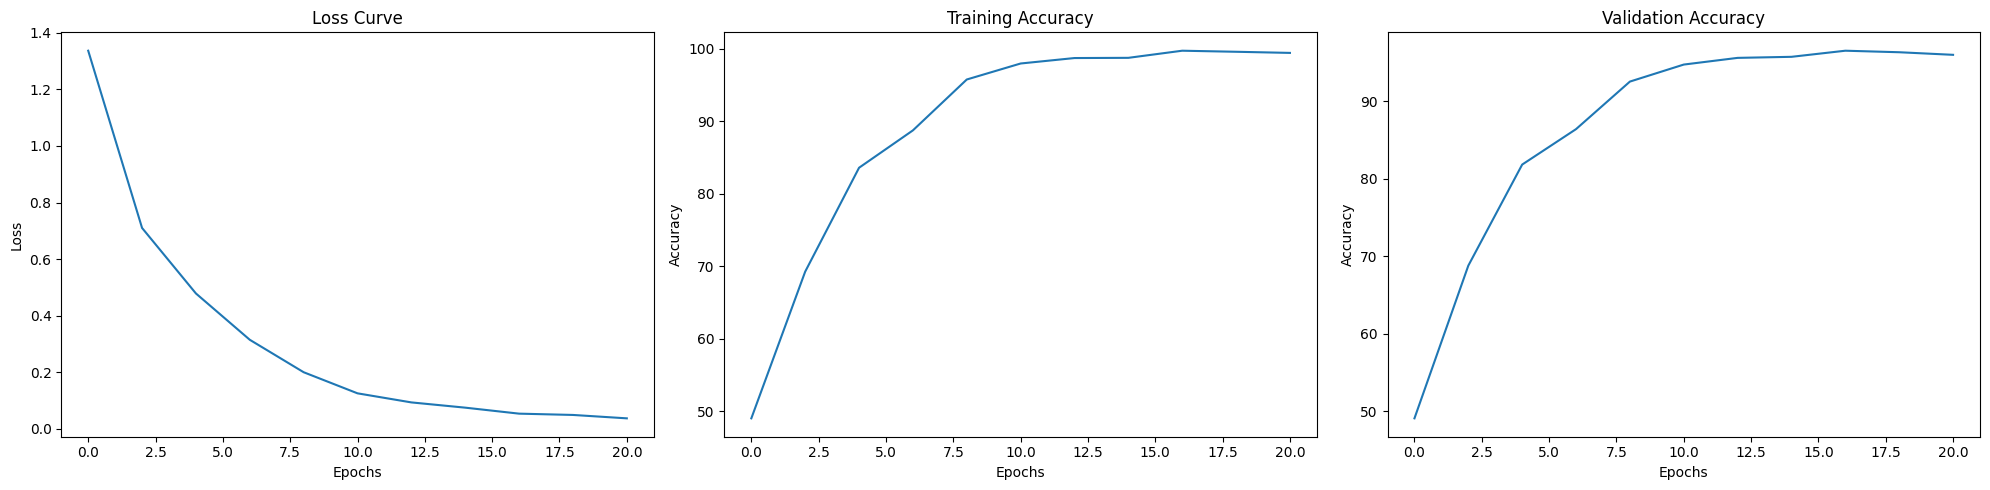

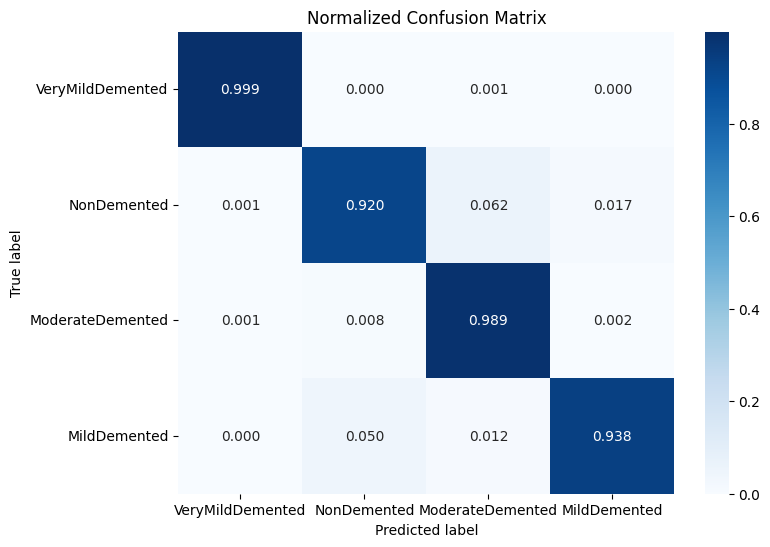

In [14]:
# Model and Hyper-parameters for CNN

model = AltzCNN().to(device)

calc_model_size_and_params(model)

#Hyper parameters
learning_rate = 3e-4
epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#train
train(model, train_loader, val_loader, epochs, criterion, optimizer, device, False)

#save_model
torch.save(model.state_dict(), f"{saved_models_path}/AltzCNN_best_model.pth")


/==============================================================================/

Transfer Learning Models

/==============================================================================/

In [18]:
############################### Transfer Learning models ###############################

def set_parameter_requires_grad(model, feature_extracting=False):
# approach 1
  if feature_extracting:
  # frozen model
      model.requires_grad_(False)
  else:
  # fine-tuning
      model.requires_grad_(True)

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == "resnet":
        model_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes) # replace the last FC layer
        input_size = 224
    elif model_name == "efficientnet":
        model_ft = models.efficientnet_b0(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
        input_size = 224

    else:
        raise NotImplementedError
    return model_ft, input_size

/==============================================================================/

Dora

/==============================================================================/

In [16]:
############################### Low Rank Layer for Dora ###############################

class LowRankLayer(nn.Module):
  def __init__(self, linear, rank, alpha, use_dora=True):
    super().__init__()
    # rank: controls the inner dimension of the matrices A and B; controls the number of additional param
    # a key factor in determining the balance between model adaptability and parameter efficiency.
    # alpha: a scaling hyper-parameter applied to the output of the low-rank adaptation,

    # controls the extent to which the adapted layer's output is allowed to influence the original output

    self.use_dora = use_dora
    self.rank = rank # low-rank
    self.alpha = alpha # scaling hyper-parameter
    self.linear = linear
    self.in_dim = linear.in_features
    self.out_dim = linear.out_features
    # weights
    std_dev = 1 / torch.sqrt(torch.tensor(self.rank).float())
    self.A = nn.Parameter(torch.randn(self.in_dim, self.rank) * std_dev)
    self.B = nn.Parameter(torch.zeros(self.rank, self.out_dim))
    self.A = nn.Parameter(self.A.to(linear.weight.device))
    self.B = nn.Parameter(self.B.to(linear.weight.device))


    if self.use_dora:
      self.m = nn.Parameter(
      self.linear.weight.norm(p=2, dim=0, keepdim=True))
    else:
      self.m = None
  def forward(self, x):
    lora = self.A @ self.B # combine LoRA matrices
    if self.use_dora:
      numerator = self.linear.weight + self.alpha * lora.T
      denominator = numerator.norm(p=2, dim=0, keepdim=True)
      directional_component = numerator / denominator
      new_weight = self.m * directional_component
      return F.linear(x, new_weight, self.linear.bias)
    else:
    # combine LoRA with orig. weights
      combined_weight = self.linear.weight + self.alpha * lora.T
      return F.linear(x, combined_weight, self.linear.bias)


/==============================================================================/

efficientnet

/==============================================================================/

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


num trainable weights:  4012672
model size: 15.47 MB


Epoch 0/15: 100%|██████████| 241/241 [01:03<00:00,  3.82batch/s, loss=0.818]


epoch: 0 loss: 0.82 train_score: 79.23 val score: 78.15


Epoch 2/15: 100%|██████████| 241/241 [01:01<00:00,  3.90batch/s, loss=0.272]


epoch: 2 loss: 0.27 train_score: 96.43 val score: 95.10


Epoch 4/15: 100%|██████████| 241/241 [01:00<00:00,  3.98batch/s, loss=0.158]


epoch: 4 loss: 0.16 train_score: 96.16 val score: 94.87


Epoch 6/15: 100%|██████████| 241/241 [01:00<00:00,  4.00batch/s, loss=0.11]


epoch: 6 loss: 0.11 train_score: 99.34 val score: 98.49


Epoch 8/15: 100%|██████████| 241/241 [01:02<00:00,  3.86batch/s, loss=0.0827]


epoch: 8 loss: 0.08 train_score: 99.46 val score: 98.62


Epoch 10/15: 100%|██████████| 241/241 [01:01<00:00,  3.90batch/s, loss=0.0736]


epoch: 10 loss: 0.07 train_score: 99.72 val score: 99.35


Epoch 12/15: 100%|██████████| 241/241 [01:03<00:00,  3.81batch/s, loss=0.0653]


epoch: 12 loss: 0.07 train_score: 99.60 val score: 99.08


Epoch 14/15: 100%|██████████| 241/241 [01:02<00:00,  3.88batch/s, loss=0.0559]


epoch: 14 loss: 0.06 train_score: 99.77 val score: 99.46


Epoch 15/15: 100%|██████████| 241/241 [01:02<00:00,  3.84batch/s, loss=0.0521]


test accuracy: 99.04689863842663
==> Finished Training ...
Training time: 1578.4592895507812 [seconds]


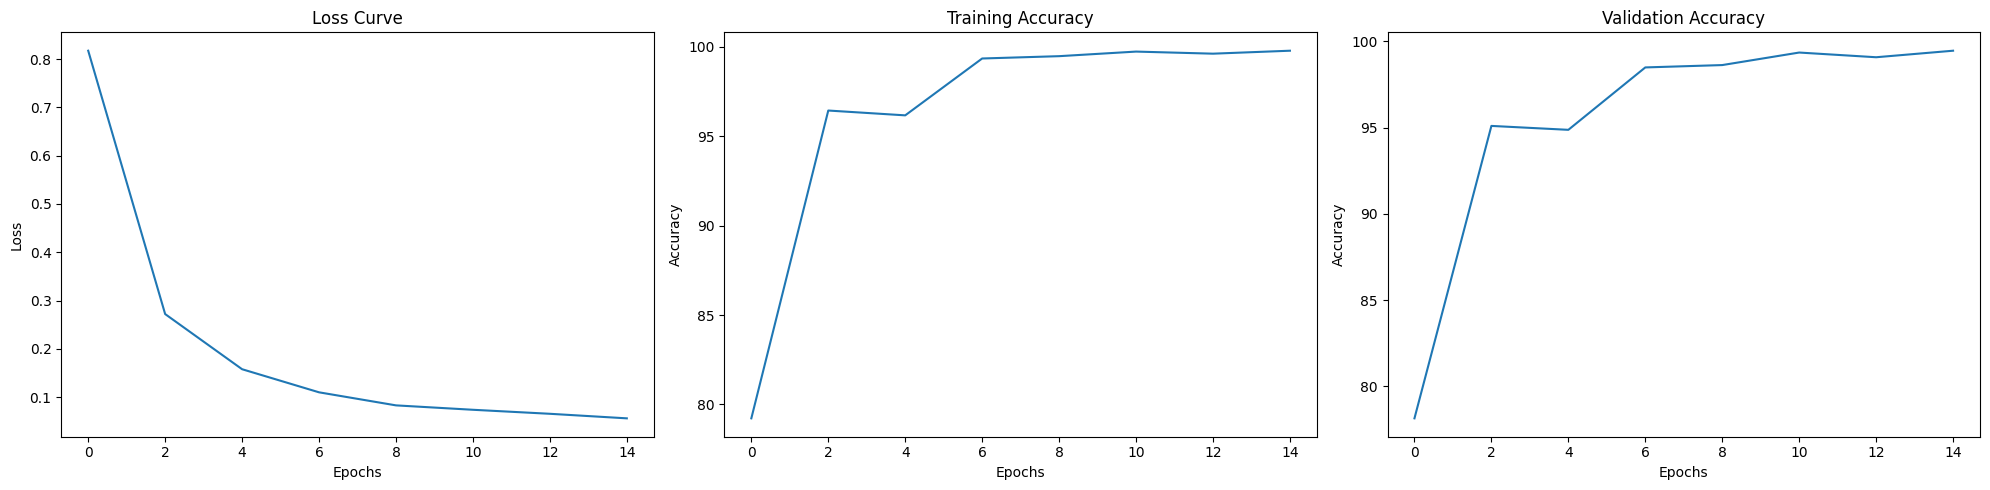

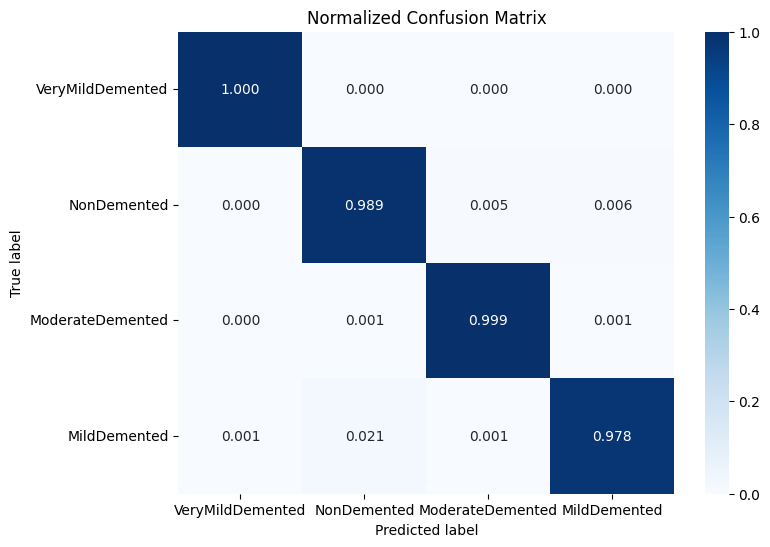

In [19]:
############################### Classifying using efficientnet  ###############################

model_name = "efficientnet"
num_classes = 4

# Flag for feature extracting. When False, we fine-tune the whole model,
# when True we only update the reshaped layer params
feature_extract = False
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
model_ft = model_ft.to(device)

calc_model_size_and_params(model_ft)

# Hyper Parameters
learning_rate = 0.001
epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=learning_rate)


#train
train(model_ft, train_loader, val_loader, epochs, criterion, optimizer_ft, device, True)

#save model
torch.save(model.state_dict(), f"{saved_models_path}/efficientnet_weights_with_alzheimer1.pth")


/==============================================================================/

efficientnet wit Dora

/==============================================================================/

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


num trainable weights:  4019088
model size: 15.49 MB


Epoch 0/10: 100%|██████████| 241/241 [01:03<00:00,  3.78batch/s, loss=1.03]


epoch: 0 loss: 1.03 train_score: 71.53 val score: 68.29


Epoch 2/10: 100%|██████████| 241/241 [01:02<00:00,  3.84batch/s, loss=0.51]


epoch: 2 loss: 0.51 train_score: 91.00 val score: 87.21


Epoch 4/10: 100%|██████████| 241/241 [01:02<00:00,  3.85batch/s, loss=0.286]


epoch: 4 loss: 0.29 train_score: 97.93 val score: 95.31


Epoch 6/10: 100%|██████████| 241/241 [01:02<00:00,  3.84batch/s, loss=0.185]


epoch: 6 loss: 0.19 train_score: 99.45 val score: 97.29


Epoch 8/10: 100%|██████████| 241/241 [01:02<00:00,  3.88batch/s, loss=0.128]


epoch: 8 loss: 0.13 train_score: 99.80 val score: 98.35


Epoch 10/10: 100%|██████████| 241/241 [01:02<00:00,  3.87batch/s, loss=0.104]


epoch: 10 loss: 0.10 train_score: 99.93 val score: 98.96
test accuracy: 98.92586989409985
==> Finished Training ...
Training time: 1131.9958102703094 [seconds]


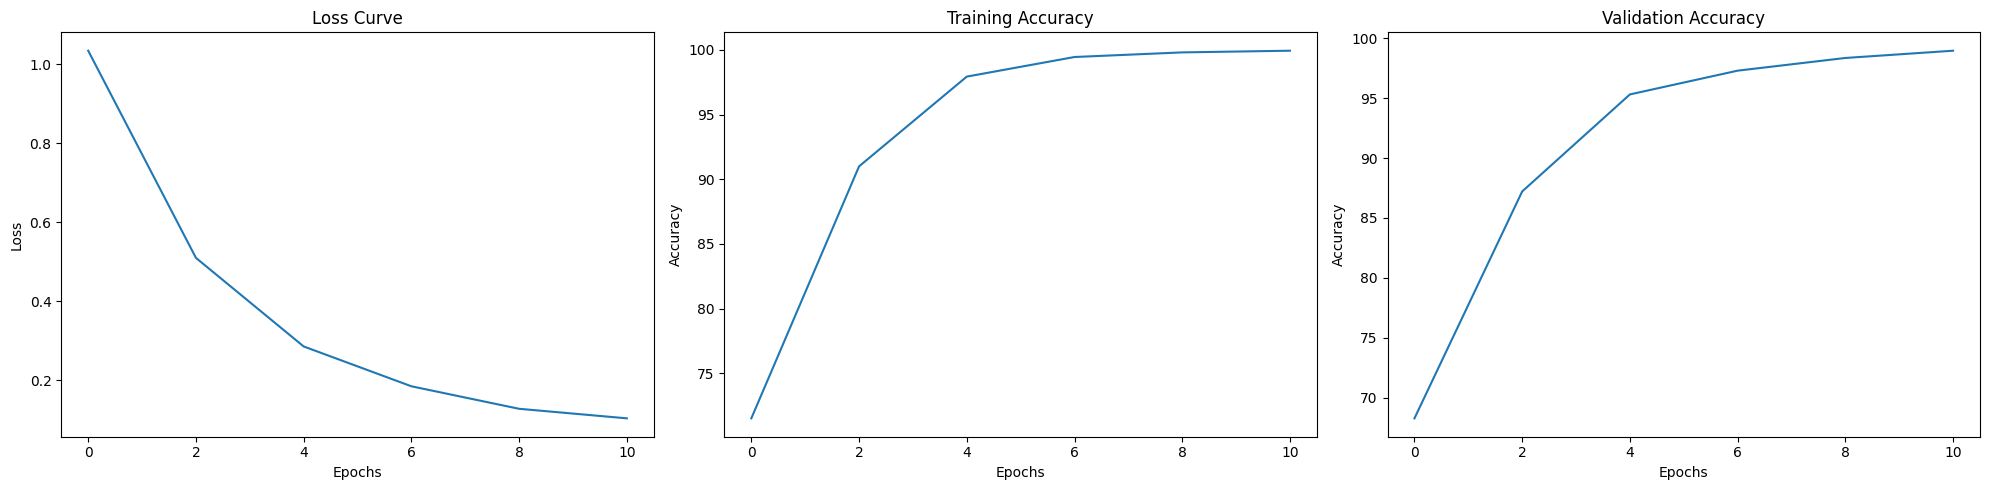

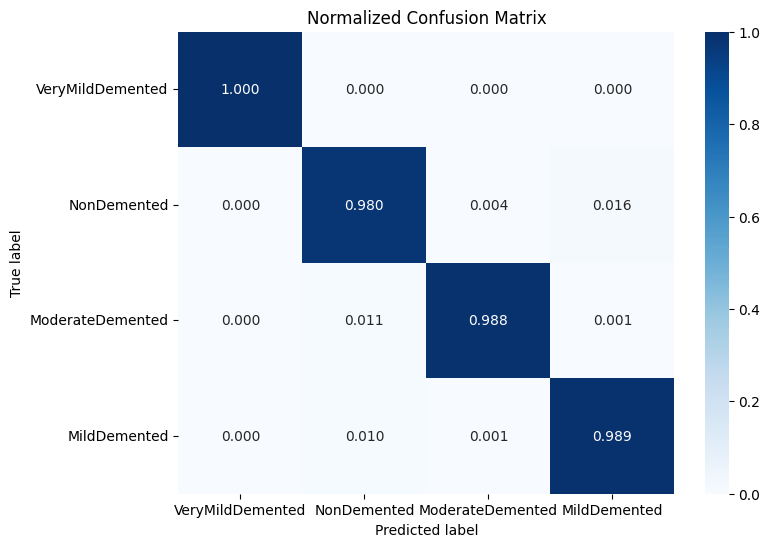

In [20]:
############################### Classifying using efficientnet with Dora ###############################

model_name = "efficientnet"
num_classes = 4

feature_extract = False
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)

# Hyper Parameters and classifier layer
rank = 4
alpha = 8
original_fc_layer = model_ft.classifier[1]
model_ft.classifier[1] = LowRankLayer(original_fc_layer, rank, alpha, use_dora=True)
learning_rate = 0.0002
epochs = 10
criterion = nn.CrossEntropyLoss()
params_to_update = [] # override the initial list definition above
for name,param in model_ft.named_parameters():
 if param.requires_grad == True:
  params_to_update.append(param)
optimizer_ft = torch.optim.Adam(params_to_update, lr=learning_rate)

calc_model_size_and_params(model_ft)

#train
train(model_ft, train_loader, val_loader, epochs, criterion, optimizer_ft, device, True)

#save_model
torch.save(model_ft.state_dict(), f"{saved_models_path}/efficientnet_weights_with_alzheimer_dora.pth")


/==============================================================================/

resnet

/==============================================================================/

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


num trainable weights:  23516228
model size: 89.91 MB


Epoch 0/10: 100%|██████████| 241/241 [01:03<00:00,  3.82batch/s, loss=0.828]


epoch: 0 loss: 0.83 train_score: 86.76 val score: 82.69


Epoch 2/10: 100%|██████████| 241/241 [01:02<00:00,  3.87batch/s, loss=0.225]


epoch: 2 loss: 0.22 train_score: 98.83 val score: 96.17


Epoch 4/10: 100%|██████████| 241/241 [01:04<00:00,  3.76batch/s, loss=0.123]


epoch: 4 loss: 0.12 train_score: 99.49 val score: 97.73


Epoch 6/10: 100%|██████████| 241/241 [01:02<00:00,  3.87batch/s, loss=0.089]


epoch: 6 loss: 0.09 train_score: 99.82 val score: 98.53


Epoch 8/10: 100%|██████████| 241/241 [01:01<00:00,  3.89batch/s, loss=0.0715]


epoch: 8 loss: 0.07 train_score: 99.88 val score: 98.68


Epoch 10/10: 100%|██████████| 241/241 [01:02<00:00,  3.83batch/s, loss=0.0575]


epoch: 10 loss: 0.06 train_score: 99.91 val score: 99.05
test accuracy: 99.03177004538578
==> Finished Training ...
Training time: 1136.682579755783 [seconds]


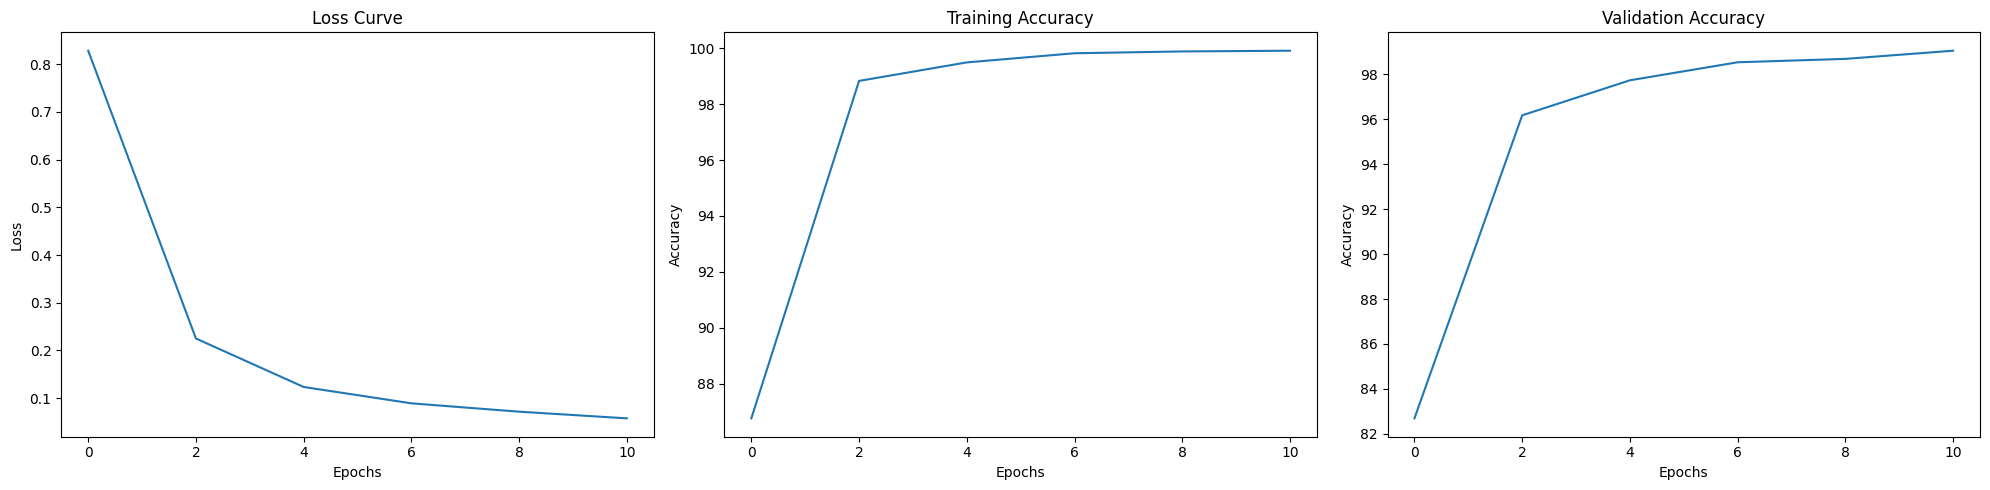

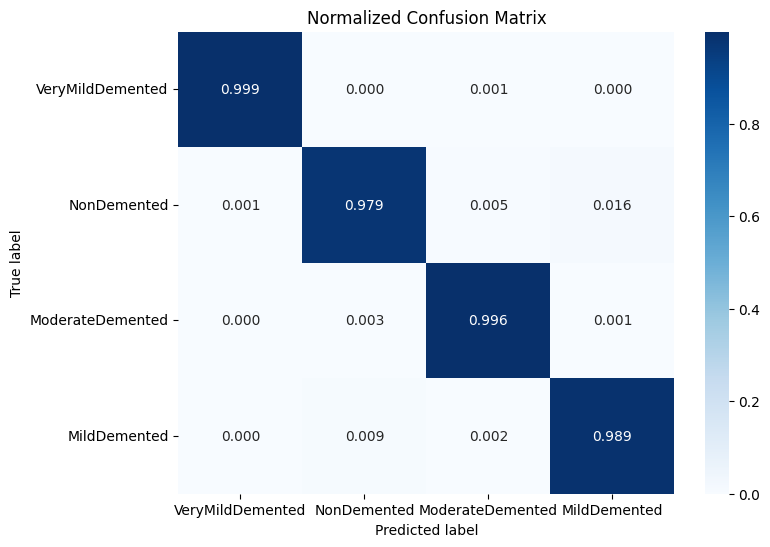

In [21]:
############################### Classifying using resnet  ###############################

model_name = "resnet"
num_classes = 4

# Flag for feature extracting. When False, we fine-tune the whole model,
# when True we only update the reshaped layer params
feature_extract = False
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)

calc_model_size_and_params(model_ft)

# Hyper Parameters
params_to_update = model_ft.parameters()
learning_rate=  0.0001
optimizer_ft = torch.optim.Adam(params_to_update, lr=learning_rate)
epochs = 10
criterion = nn.CrossEntropyLoss()

#train
train(model_ft, train_loader, val_loader, epochs, criterion, optimizer_ft, device, True)

#save model
torch.save(model_ft.state_dict(), f"{saved_models_path}/resnet_weights_with_alzheimer.pth")

/==============================================================================/

resnet with Dora

/==============================================================================/

num trainable weights:  23526484
model size: 89.95 MB


Epoch 0/10: 100%|██████████| 241/241 [01:02<00:00,  3.83batch/s, loss=0.69]


epoch: 0 loss: 0.69 train_score: 88.44 val score: 85.35


Epoch 2/10: 100%|██████████| 241/241 [01:02<00:00,  3.87batch/s, loss=0.169]


epoch: 2 loss: 0.17 train_score: 97.67 val score: 95.69


Epoch 4/10: 100%|██████████| 241/241 [01:01<00:00,  3.91batch/s, loss=0.0995]


epoch: 4 loss: 0.10 train_score: 99.70 val score: 98.71


Epoch 6/10: 100%|██████████| 241/241 [01:01<00:00,  3.92batch/s, loss=0.074]


epoch: 6 loss: 0.07 train_score: 99.78 val score: 99.11


Epoch 8/10: 100%|██████████| 241/241 [01:01<00:00,  3.89batch/s, loss=0.0561]


epoch: 8 loss: 0.06 train_score: 99.82 val score: 98.85


Epoch 10/10: 100%|██████████| 241/241 [01:01<00:00,  3.93batch/s, loss=0.0492]


epoch: 10 loss: 0.05 train_score: 99.91 val score: 99.11
test accuracy: 99.1376701966717
==> Finished Training ...
Training time: 1117.9091019630432 [seconds]


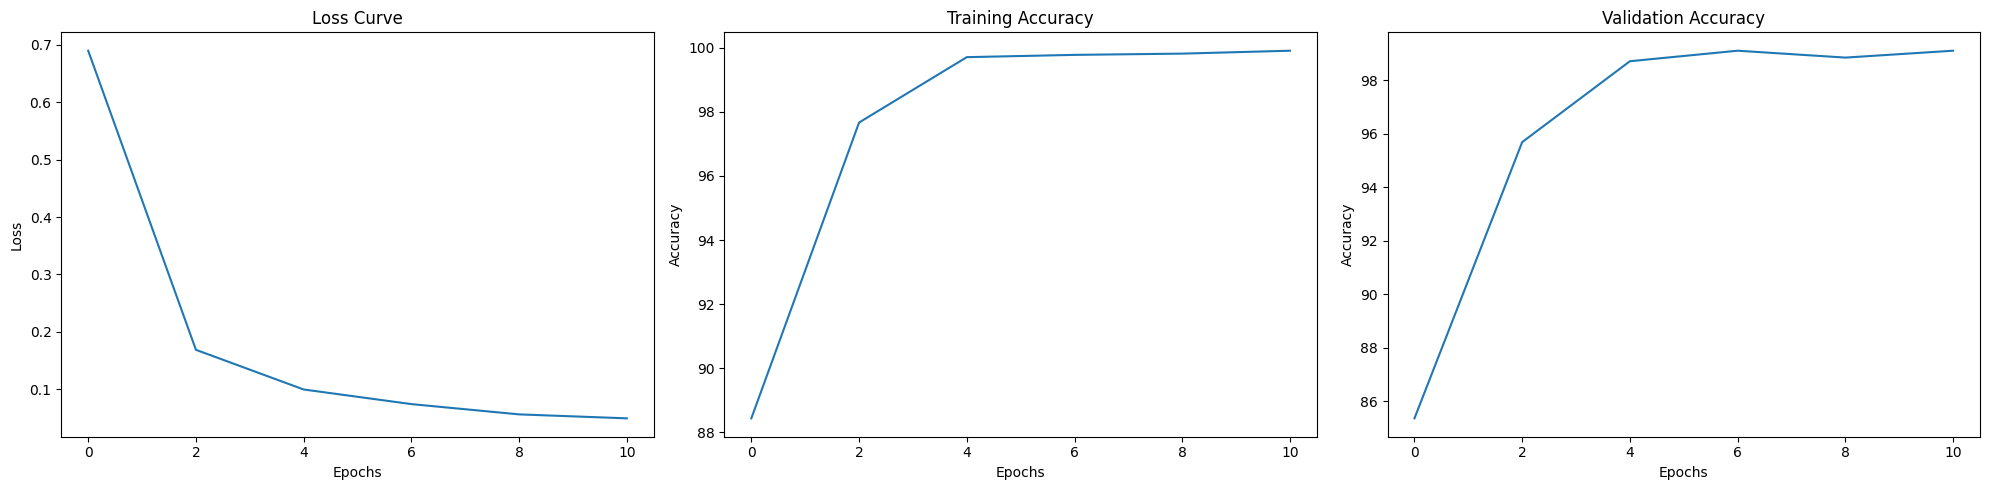

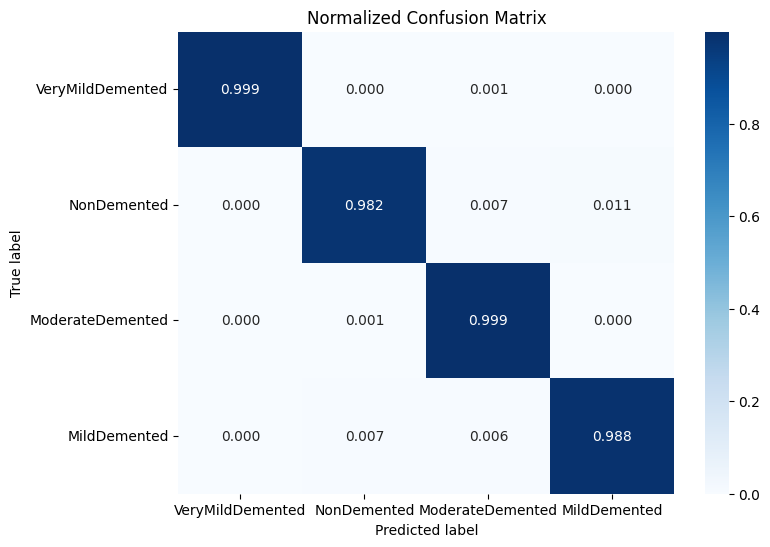

In [30]:
############################### Classifying using resnet with Dora ###############################

model_name = "resnet"
num_classes = 4

# Flag for feature extracting. When False, we fine-tune the whole model,
# when True we only update the reshaped layer params
feature_extract = False
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)

# Hyper Parameters and classifier layer
learning_rate = 0.0002
epochs = 10
criterion = nn.CrossEntropyLoss()
rank = 4
alpha = 8
original_fc_layer = model_ft.fc
model_ft.fc = LowRankLayer(original_fc_layer, rank, alpha, use_dora=True)
params_to_update = [] # override the initial list definition above
for name,param in model_ft.named_parameters():
 if param.requires_grad == True:
  params_to_update.append(param)
optimizer_ft = torch.optim.Adam(params_to_update, lr=learning_rate)


calc_model_size_and_params(model_ft)


#train
train(model_ft, train_loader, val_loader, epochs, criterion, optimizer_ft, device, True)

#save model
torch.save(model_ft.state_dict(), f"{saved_models_path}/resnet_weights_with_alzheimer_dora.pth")

device = cuda:0
choosing random picture from the train set...
shape of the image divided to patches: torch.Size([196, 3, 16, 16])


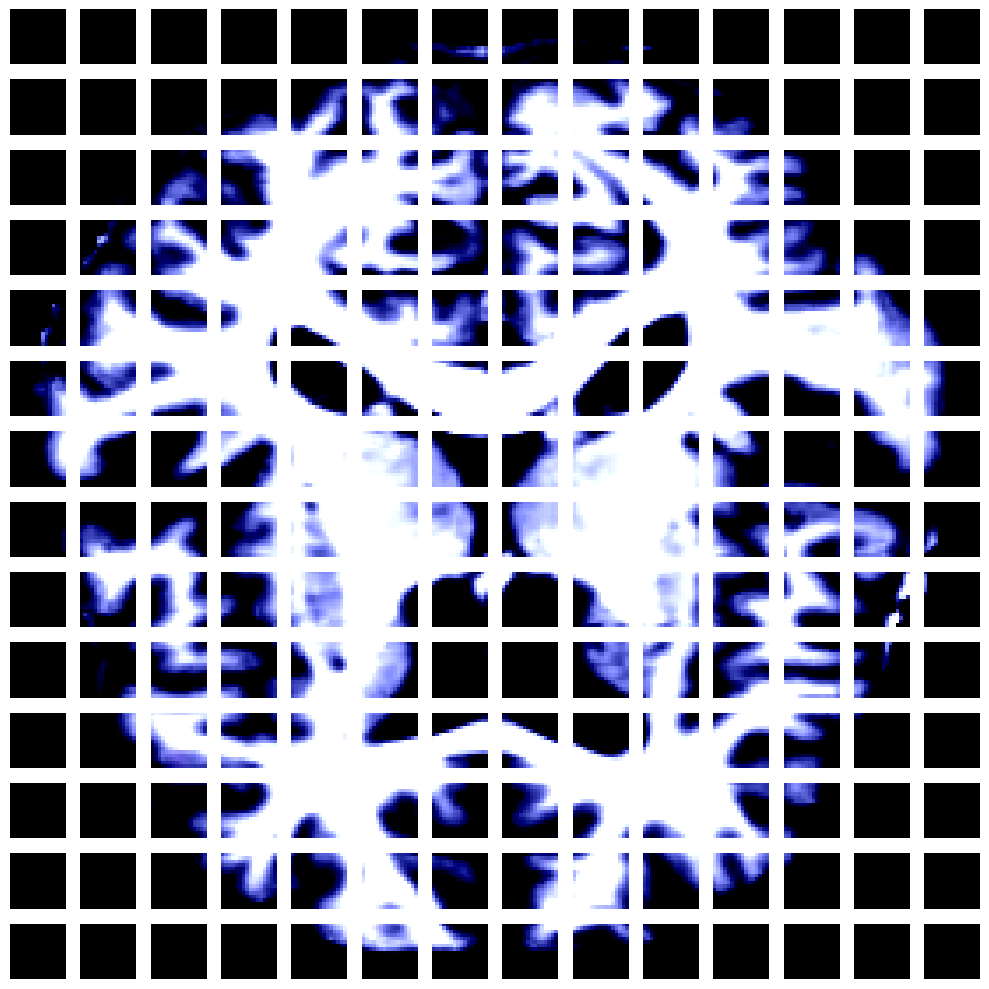

shape of the sequenced patch: torch.Size([196, 768])


In [15]:
############################### Vision Transform ###############################

def divide_to_patches(image, patch_size=16, grid_w=14, grid_h=14):
    image_width, image_height = image.shape[1], image.shape[2]
    num_of_patches = (image_width // patch_size) * (image_height // patch_size)
    patches_list = []
    patches = np.zeros((num_of_patches, 3, patch_size, patch_size))
    for i in range(grid_h):
        for j in range(grid_w):
            patches_list.append(image[0:3, i*patch_size : (i+1)*patch_size, j*patch_size : (j+1)*patch_size])
    for i in range(len(patches_list)):
        patches[i] = patches_list[i]
    return torch.Tensor(patches)

def flatten_patch_to_sequence(patch):
    flattened_tensor = patch.view(196, -1)
    return flattened_tensor

def show_image_patches(patches: torch.Tensor, grid_width=14, grid_height=14):
    num_images = patches.shape[0]
    fig, axes = plt.subplots(grid_width, grid_height, figsize=(10, 10))
    for i in range(num_images):
        part_of_image = patches[i].clamp(0, 1).numpy()
        ax = axes[i // grid_width, i % grid_height]
        ax.imshow(part_of_image.transpose(1, 2, 0))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def show_sequenced_patch(patches: torch.Tensor, grid_width=14, grid_height=14):
    num_images = patches.shape[0]
    fig, axes = plt.subplots(1, grid_width * grid_height, figsize=(30, 1))
    for i in range(num_images):
        part_of_image = patches[i].clamp(0, 1).numpy()
        ax = axes[i]
        ax.imshow(part_of_image.transpose(1, 2, 0))
        ax.axis('off')
    plt.show()

IMAGE_SIZE = 224

# Dataset root directory
ViT_pre_trained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Create the dataset
dataset = AlzheimerDataset(root_dir=dataset_root, transform= ViT_pre_trained_weights.transforms())

# Calculate split sizes
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

# Check device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device = {device}")

print('choosing random picture from the train set...')
random_picture_idx = random.randint(0, len(train_dataset) - 1)
picture_position = 0
output_patched_image = divide_to_patches(train_dataset[random_picture_idx][picture_position])
print(f'shape of the image divided to patches: {output_patched_image.shape}')
show_image_patches(output_patched_image)
sequenced_patch = flatten_patch_to_sequence(output_patched_image)
print(f'shape of the sequenced patch: {sequenced_patch.shape}')
show_sequenced_patch(output_patched_image)

In [ ]:
# get the weights of pre-trained model. DEFAULT = IMAGENET1K_V1
ViT_pre_trained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# define ViT pre-trained model with DEFAULT weights.
ViT_pre_trained_model = torchvision.models.vit_b_16(weights=ViT_pre_trained_weights)

# we need to use the same transform on our dataset so the
ViT_transform = ViT_pre_trained_weights.transforms()
# define our model
mlp_fine_tune_model = ViT_pre_trained_model

# freezing the base params
for param in mlp_fine_tune_model.parameters():
    param.requires_grad = True

print(mlp_fine_tune_model)
print(f"locating the mlp layer that needs to be adapted for our specific task - {mlp_fine_tune_model.heads}")
# changing the mlp layer to match for the new task - plants classification
mlp_fine_tune_model.heads = nn.Linear(in_features=768, out_features=4, bias=True)

set_parameter_requires_grad(mlp_fine_tune_model)

print(f"MLP layer - {mlp_fine_tune_model.heads}")

mlp_fine_tune_model.to(device)
params_to_update = mlp_fine_tune_model.parameters()

calc_model_size_and_params(mlp_fine_tune_model)

# Hyper Parameters
learning_rate = 0.0001
optimizer_ft = torch.optim.Adam(params_to_update, lr=learning_rate)
criterion = nn.CrossEntropyLoss()
epochs = 10


#train
train(mlp_fine_tune_model, train_loader, val_loader, epochs, criterion, optimizer_ft, device, True)

#save_model
torch.save(mlp_fine_tune_model.state_dict(), f"{saved_models_path}/vit_alzheimer1.pth")


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Epoch 0/10:   0%|          | 0/482 [00:00<?, ?batch/s]

In [ ]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Ensure the model is in evaluation mode
mlp_fine_tune_model.eval()

# Collect the representations and labels
representations = []
labels = []
class_names = ['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented']
num_classes = 4

with torch.no_grad():
    for images, label in train_loader:
        images = images.to(device)
        outputs = mlp_fine_tune_model(images)
        cls_token_representation = outputs.detach().cpu().numpy()  # Assuming this is the [CLS] token representation
        representations.extend(cls_token_representation)
        labels.extend(label.cpu().numpy())

representations = np.array(representations)
labels = np.array(labels)

# Apply t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
reduced_representations = tsne.fit_transform(representations)
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    indices = labels == i
    plt.scatter(reduced_representations[indices, 0], reduced_representations[indices, 1], label=class_names[i], s=20)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of ViT Representations (2D)')
plt.legend()
plt.show()

# 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

tsne = TSNE(n_components=3, random_state=42)
reduced_representations = tsne.fit_transform(representations)
for i in range(num_classes):
    indices = labels == i
    ax.scatter(reduced_representations[indices, 0],
               reduced_representations[indices, 1],
               reduced_representations[indices, 2],
               label=class_names[i],
               s=20)

ax.set_xlabel('t-SNE Dimension 1',labelpad=20)
ax.set_ylabel('t-SNE Dimension 2',labelpad=20)
ax.set_zlabel('t-SNE Dimension 3',labelpad=20)
ax.set_title('t-SNE Visualization of ViT Representations (3D)')
ax.legend()

plt.show()

# Summery

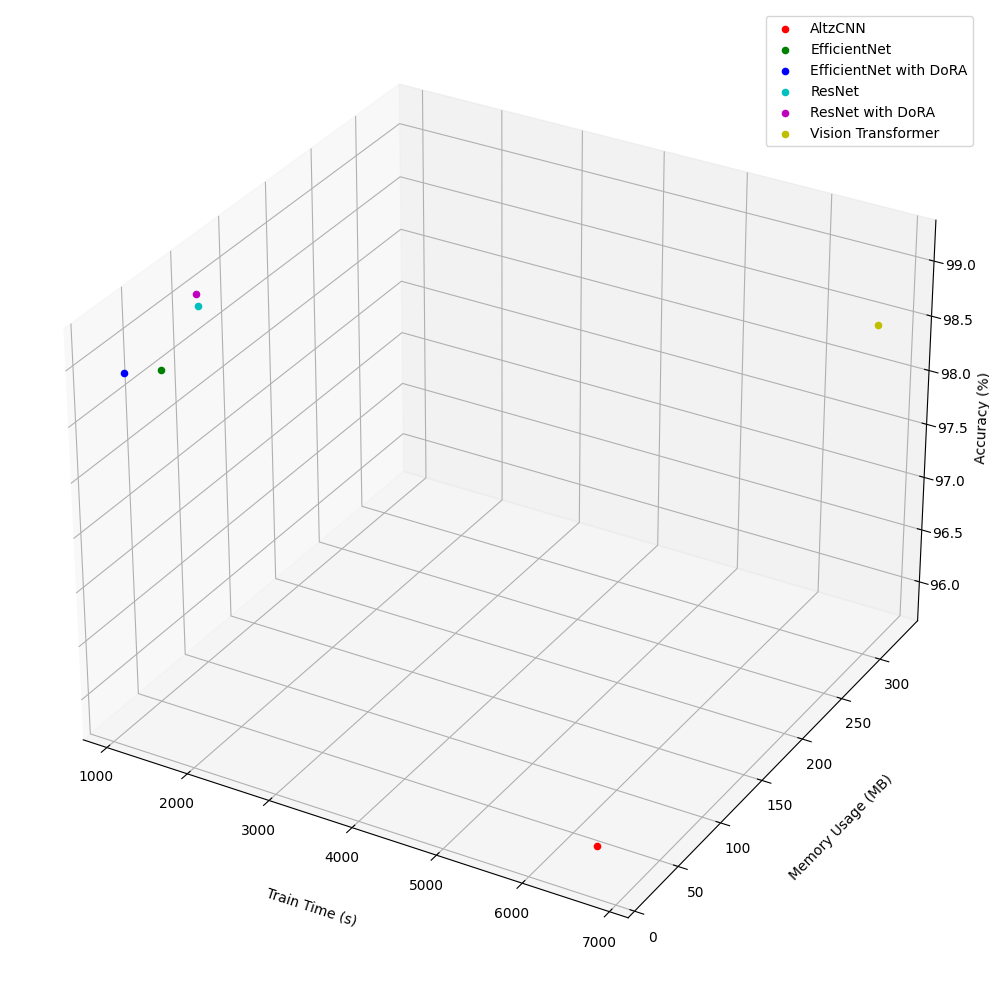

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data for each model
models = ['AltzCNN', 'EfficientNet', 'EfficientNet with DoRA', 'ResNet', 'ResNet with DoRA', 'Vision Transformer']
train_time = [6553, 1578, 1132, 1137, 1117, 6798]
memory = [22.93, 15.47, 15.49, 89.91, 89.95, 327.31]
accuracy = [95.86, 99.04, 98.92, 99.03, 99.13, 98.48]

# Assign a unique color for each model
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each point with a different color and marker
for i, model in enumerate(models):
    ax.scatter(train_time[i], memory[i], accuracy[i], c=colors[i], marker='o', label=model)
    # # Annotate each point with its values
    # ax.text(train_time[i], memory[i], accuracy[i], f'({train_time[i]}, {memory[i]:.2f}, {accuracy[i]:.2f})', fontsize=9)

# Add labels
ax.set_xlabel('Train Time (s)',labelpad=20)
ax.set_ylabel('Memory Usage (MB)',labelpad=20)
ax.set_zlabel('Accuracy (%)',labelpad=4)

# Add a legend to show the model names
ax.legend()

plt.tight_layout()

# Show the plot
plt.show()
